# Gridsearch SARIMA Models
(core)


*Christina Brockway*

### Zillow Data

You will continue working with Zillow's publicly available Zillow House Value Index (ZHVI) that you prepared for a previous core assignment. https://www.zillow.com/research/data/

*  You can start working in the same notebook you used for the Preparing Time Series from Wide-Form Data (Core) assignment
*  Specifically, you will be using the Home Value data set for:
    *  Data Type = "ZHVI All Homes (SFR+Condo/Coop) - Time Series - Smoothed - Seasonally Adjusted"
    *  Geography = "City"
*  We have already downloaded the file for you and uploaded it to Google Drive.
    *  Share URL: https://drive.google.com/file/d/1O_g44QAfe3uVF-1heAC0BAeVDoWloVR-/view?usp=sharing
    *  Direct URL (for Pandas): https://docs.google.com/spreadsheets/d/e/2PACX-1vQN3Ksa9szQuO4G1-msXWAp17KtVHQCBnuEieu_auu1wSiBf3-krHusIx5VBMkihxj-KZLBosDIGEyR/pub?output=csv



### Review: Previous Assignment

In a core assignment from last week (Preparing Time Series from Wide-Form Data (Core)), you worked with this dataset.

    *  You filtered the data to keep only the 4 largest cities based on their "SizeRank"
    *  You melted the wide-form data for the 4 largest cities into long-form time series with a datetime index.
    *  You resampled the data to monthly frequency, grouped by City.
    *  You performed EDA and answered some questions comparing the cities, including selecting the city that had the highest home value at the end of 2008 and the one that had the lowest value at the end of 2008.




### Time Series Models for Home Values

Your overall goal is to forecast the home values for the city with the highest home value in 2008(New York) 6months into the future (beyond the dataset).

 *  Filter the dataset only to include values starting in 2018
 *  Check for and address null values.
 *  Decompose the Time series to detect seasonality and decide if your model should or should not have a seasonal component
 *  Determine Time Series Model Orders
    *  Check the time series for stationarity.
        *  Determine the number of differencing needed to make the data stationary
    *  Check the ACF/PACF Plots of the differenced data to determine the orders
 *  Split the time series into training and test data (Remember we want to predict 6 months, and our data has been resampled to monthly)
 *  Fit a manual ARIMA/SARIMA model based on the orders determined during your exploration.
    *  Make forecasts with your model.
    *  Plot the forecasts versus the test data
    *  Obtain metrics for evaluation
 *  Tune with pmdarima's auto_arima
    *  Fit a model on training data with the best parameters from auto_arima
    *  Obtain metrics for evaluation
    *  Make forecasts with the auto_arima model
    *  Plot the forecasts versus the test data
 *  Select your final model
 *  Make true future forecasts using the entire dataset (for dates beyond the entire ts).
    *  Calculate the predicted net change in home value for the forecasted period as both:
         *  Raw values for change in the final month in the forecast vs. the first month.
        *  Convert the raw delta into a percent change.
       
 

**Answer the following questions in a Markdown cell**

    -  What is the predicted home value in New York City 6 months into the future (beyond the dataset)?
    -  What is the percent change in home values in New York City by the end of the 6-month forecast (beyond the dataset)?
    

# Imports, Functions, Load Data

In [20]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs

# Set wide fig size for plots
plt.rcParams['figure.figsize']=(12,3)

#import tick customization tools
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
sns.set_context("talk", font_scale=0.9)

import pmdarima as pm

In [2]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax



In [3]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])



In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics



In [5]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig



In [21]:
def thousands(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000
    return f"{new_x:,.0f}K"
# Create the formatter
fmt_thous = mticks.FuncFormatter(thousands)

In [7]:
df = pd.read_csv('data/Filtered_Largest_City.csv')
df

,RegionName,Date,RegionName.1,HomeValue
0,Chicago,2000-01-01,Chicago,166139.0
1,Chicago,2000-02-01,Chicago,166536.0
2,Chicago,2000-03-01,Chicago,167368.0
3,Chicago,2000-04-01,Chicago,168826.0
4,Chicago,2000-05-01,Chicago,170499.0
...,...,...,...,...
1082,New York,2022-05-01,New York,768797.0
1083,New York,2022-06-01,New York,773944.0
1084,New York,2022-07-01,New York,777692.0
1085,New York,2022-08-01,New York,779960.0


In [8]:
# Make the date column a datetime object and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df.index

DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01',
               ...
               '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
               '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
               '2022-08-01', '2022-09-01'],
              dtype='datetime64[ns]', name='Date', length=1087, freq=None)

### Filter Dataset
- New York only
- from 2018 and up

In [10]:
df_ny = df[df['RegionName']=='New York']
df_ny

,RegionName,RegionName.1,HomeValue
Date,,,
2000-01-01,New York,New York,253690.0
2000-02-01,New York,New York,255517.0
2000-03-01,New York,New York,257207.0
2000-04-01,New York,New York,260310.0
2000-05-01,New York,New York,263204.0
...,...,...,...
2022-05-01,New York,New York,768797.0
2022-06-01,New York,New York,773944.0
2022-07-01,New York,New York,777692.0


In [12]:
dfny= df_ny[['HomeValue']]
dfny

,HomeValue
Date,
2000-01-01,253690.0
2000-02-01,255517.0
2000-03-01,257207.0
2000-04-01,260310.0
2000-05-01,263204.0
...,...
2022-05-01,768797.0
2022-06-01,773944.0
2022-07-01,777692.0


In [24]:
# filter years 2018 and greater

dfny2018 = dfny.loc['2018':]
dfny2018

,HomeValue
Date,
2018-01-01,656700.0
2018-02-01,661012.0
2018-03-01,665672.0
2018-04-01,669989.0
2018-05-01,673514.0
2018-06-01,676434.0
2018-07-01,678984.0
2018-08-01,681140.0
2018-09-01,683546.0


### Check for and Address Nulls

In [25]:
dfny2018.isna().sum()

HomeValue    0
dtype: int64

* There are no null values to impute.

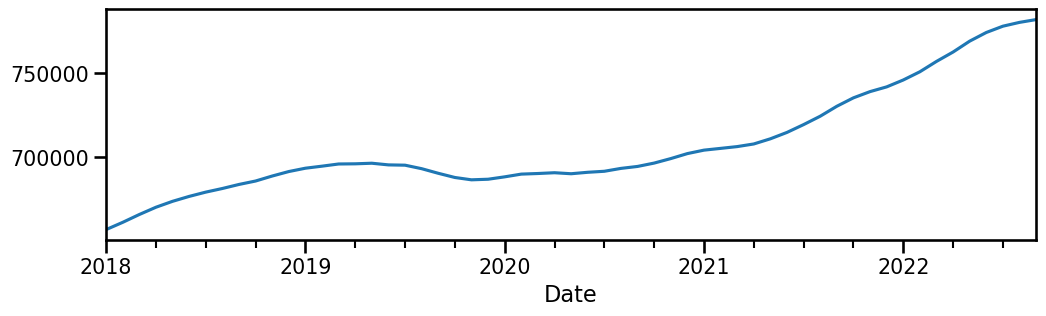

In [27]:
# Set frequency to first day of the month
dfny2018= dfny2018.asfreq('MS')
# Define the time series
ts = dfny2018['HomeValue']
ts.plot();


### Seasonality

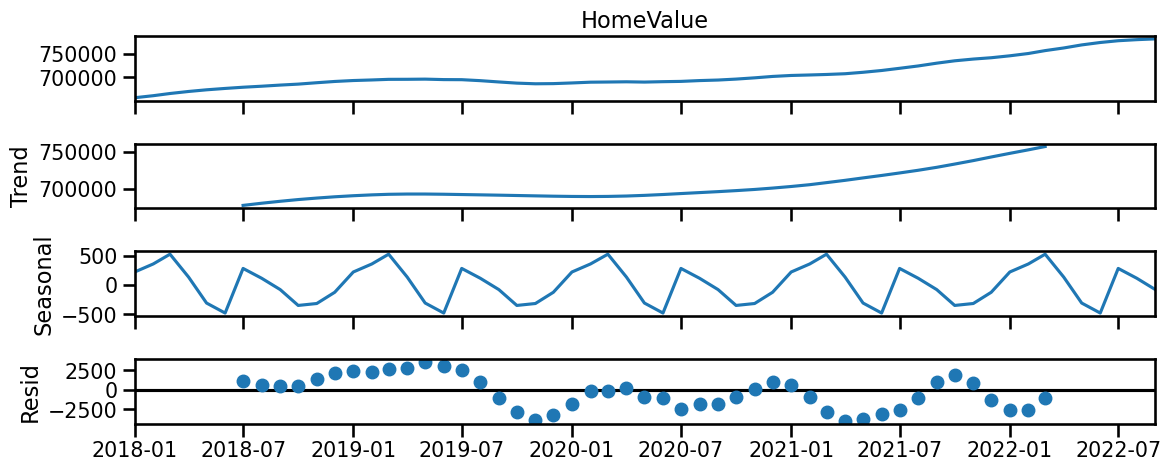

In [28]:
# Apply seasonal decomposition
decomp = tsa.seasonal_decompose(ts)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()


In [29]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()

# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta: .2f} which is ~{seasonal_delta/(ts.max()-ts.min()) * 100 :.2f}% of the variation in time series.")


The seasonal component is  1006.13 which is ~0.81% of the variation in time series.


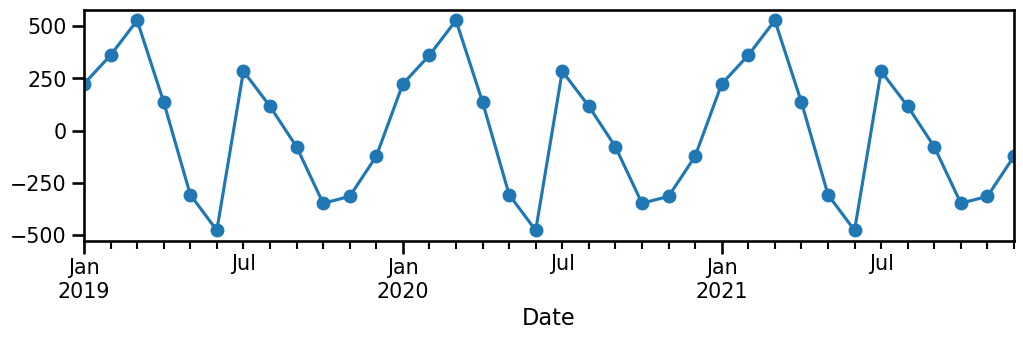

In [30]:
# Narrow down the date range of the plot
seasonal = decomp.seasonal
ax = seasonal.loc['2019': '2021'].plot(marker = 'o')


*  There appears to be some seasonality
*  There are 4 points before the 1st peak
*  There are 8 point until the second peak
*  Or there are 12 points between seasons  m=12

### Determine Parameters

#### Check Stationarity and Differencing

In [31]:
# Check for stationarity
get_adfuller_results(ts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,0.407572,4,52,0.981776,0.05,False


*  This dataset will need to be differenced

In [32]:
# determine d
d = ndiffs(ts)
print (f'd = {d}')
# determine D
D = nsdiffs(ts, m = 12)
print (f'D = {D}')


d = 2
D = 0


In [34]:
get_adfuller_results(tsdiff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-5.461615,2,52,0.000003,0.05,True


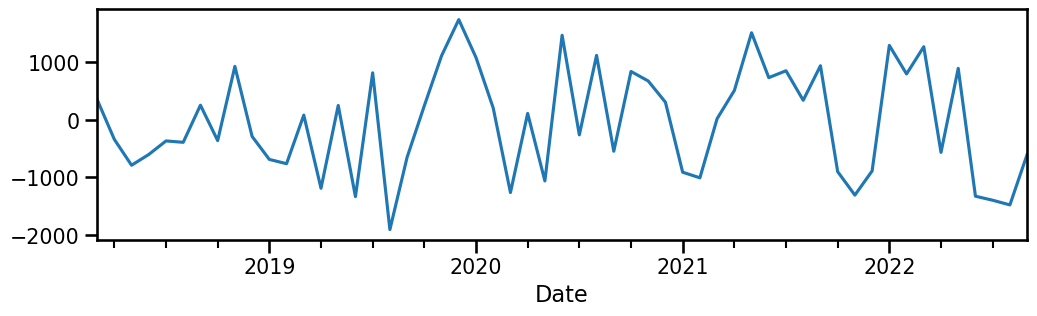

In [33]:
# apply differencing
tsdiff= ts.diff().diff().dropna()
tsdiff.plot();


### ACF/PACF Evaluation

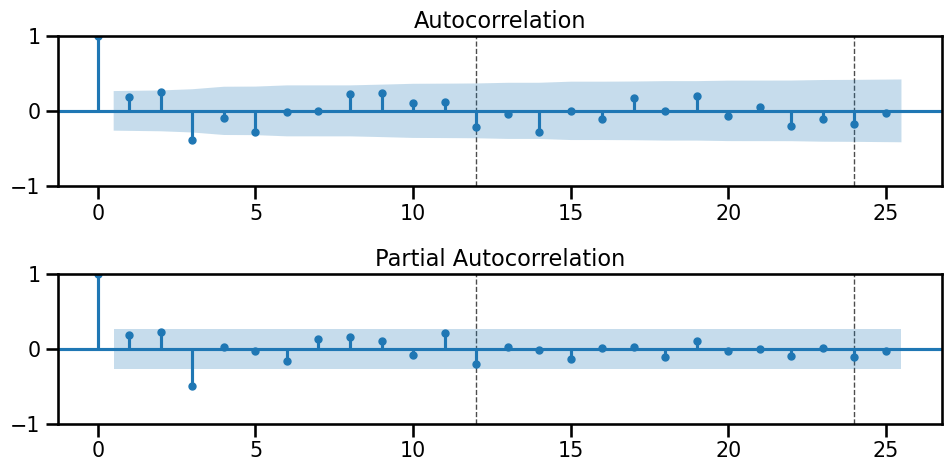

In [43]:
plot_acf_pacf(tsdiff, annotate_seas = True, m=12, nlags=25);

***For p and q:**
   * ACF appears to have a drop at lag 3
   * PACF appears to have a drop at lag 3
   * Will use p=3 and q=3

***For { and Q:**
   * ACF appears to have a gradual decrease
   * PACF appears to have a gradual decrease
   * Will use P=1 and Q=1

* Start with (3,2,3)(1,0,1)[12]

### Train Test Split 

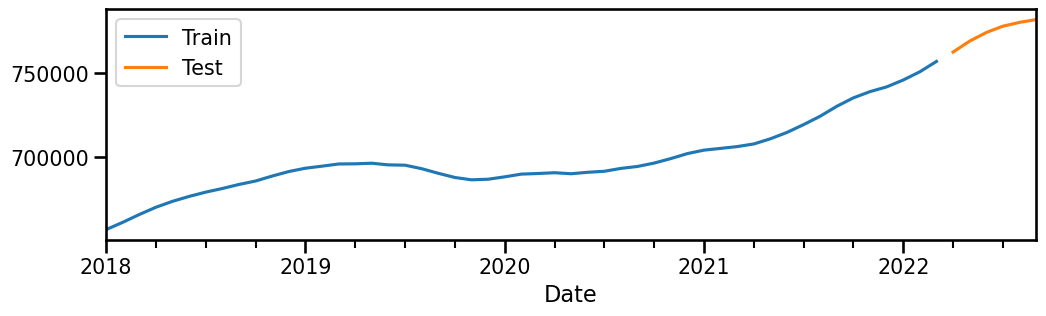

In [46]:
# tts
train, test = train_test_split(ts, test_size=6)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

### Fit OG Model

In [48]:
#Fit model

# Orders for non seasonal components
p = 3  # nonseasonal AR
d = 2  # nonseasonal differencing
q = 3  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

og_model = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 4,301.086
- MSE = 37,429,951.445
- RMSE = 6,118.002
- R^2 = 0.170
- MAPE = 0.55%


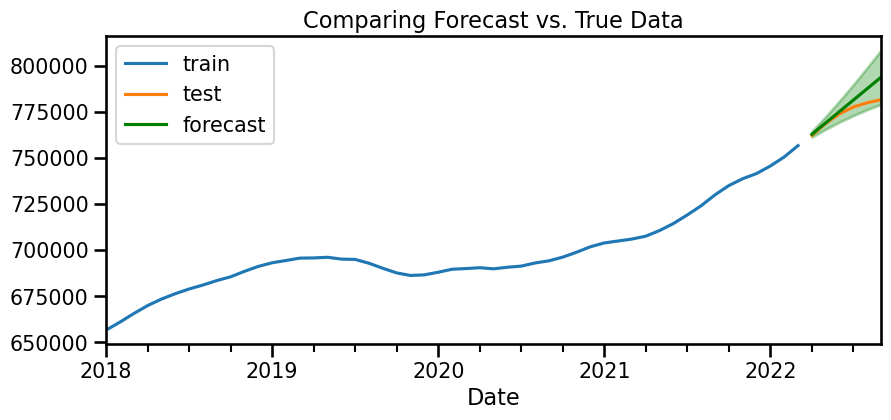

In [65]:
# Obtain summary of forecast as dataframe
forecast_dfog = og_model.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_dfog)
# Obtain metrics
regression_metrics_ts(test, forecast_dfog["mean"])


In [50]:
og_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          HomeValue   No. Observations:                   51
Model:             ARIMA(3, 2, 3)x(1, 0, [1], 12)   Log Likelihood                -401.853
Date:                            Fri, 01 Dec 2023   AIC                            821.706
Time:                                    00:58:02   BIC                            838.732
Sample:                                01-01-2018   HQIC                           828.165
                                     - 03-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1093      8.606      0.013      0.990     -16.758      16.977
ar.L2          0.6950      3.036      0.229      0.819      -5.255       6.645
ar.L3          0.0040      5.146      0.001      0.999     -10.081      10.089
ma.L1         -0.1092      8.609     -0.013      0.990     -16.983      16.765
ma.L2         -0.6908      3.034     -0.228      0.820      -6.638       5.256
ma.L3         -0.0015      5.116     -0.000      1.000     -10.029      10.026
ar.S.L12       0.2643      2.349      0.113      0.910      -4.340       4.868
ma.S.L12      -0.2625      2.352     -0.112      0.911      -4.873       4.348
sigma2      6.112e+05      0.000   4.91e+09      0.000    6.11e+05    6.11e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.65   Jarque-Bera (JB):                 1.54
Prob(Q):                              0.42   Prob(JB):                         0.46
Heteroskedasticity (H):               2.72   Skew:                            -0.18
Prob(H) (two-sided):                  0.05   Kurtosis:                         2.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.7e+26. Standard errors may be unstable.
"""

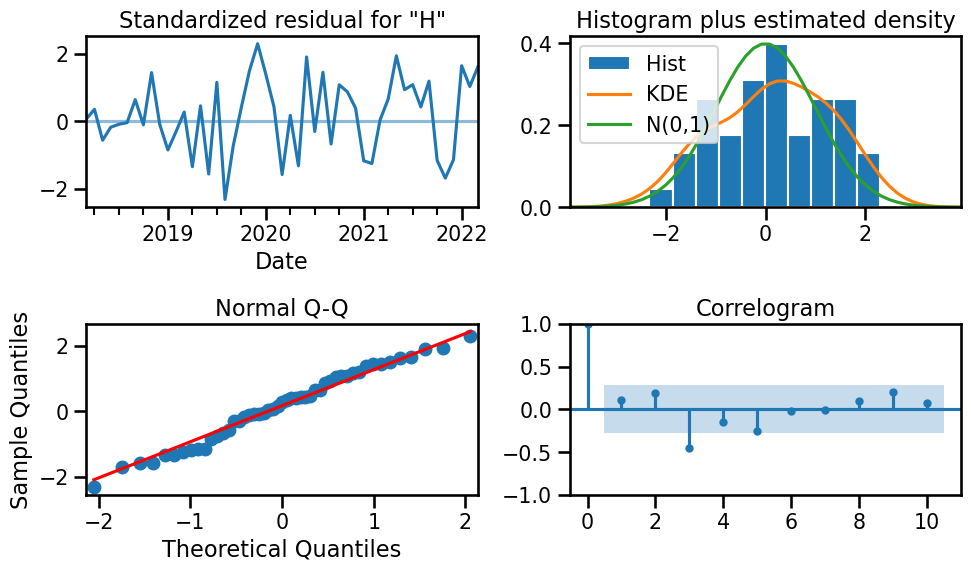

In [51]:
# Obtain diagnostic plots
fig = og_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()


* MAPE shows an excellent rating for this model
* Correlogram and coefficients show maybe some of the fluctuations were not captured well

### Use Gridsearch to find best params

In [53]:
# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    seasonal=True,  
    m=12,
    trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1040.350, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=909.717, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=930.101, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=912.587, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=940.569, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=911.717, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=911.717, Time=0.01 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=913.717, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=928.324, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=910.593, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=907.207, Time=0.10 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=909.209, Time=0.21 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=1024.876, Time=0.10 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=911.393, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[12] interc

In [54]:
# the auto_arima will store our best nonseasonal and seasonal orders separtely
print(auto_model.order)
print(auto_model.seasonal_order)


(1, 1, 1)
(0, 0, 0, 12)


In [55]:
# Orders for non seasonal components
p = 1 # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1 # nonseasonal MA

# Orders for seasonal components
P = 0 # Seasonal AR
D = 0  # Seasonal differencing
Q = 0  # Seasonal MA
m = 12 # Seasonal period

auto_sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Or instead of manually defining the orders, you can obtain them programmatically
# auto_sarima = tsa.ARIMA(train, order = auto_model.order, seasonal_order = auto_model.seasonal_order)

# Obtain model summary
auto_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              HomeValue   No. Observations:                   51
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -453.364
Date:                Fri, 01 Dec 2023   AIC                            912.728
Time:                        01:08:07   BIC                            918.464
Sample:                    01-01-2018   HQIC                           914.913
                         - 03-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.008    123.554      0.000       0.984       1.016
ma.L1         -0.9996      0.096    -10.382      0.000      -1.188      -0.811
sigma2      4.781e+06   5.86e-09   8.15e+14      0.000    4.78e+06    4.78e+06
===================================================================================
Ljung-Box (L1) (Q):                  39.13   Jarque-Bera (JB):                 0.51
Prob(Q):                              0.00   Prob(JB):                         0.77
Heteroskedasticity (H):               1.93   Skew:                            -0.20
Prob(H) (two-sided):                  0.19   Kurtosis:                         2.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.22e+30. Standard errors may be unstable.
"""

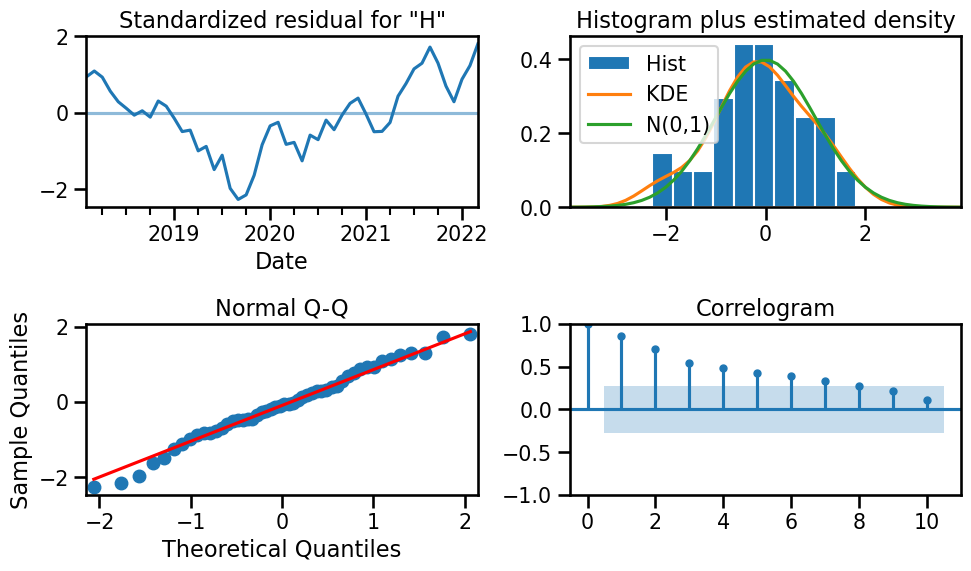

In [56]:
# Obtain diagnostic plots
fig = auto_sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 9,586.366
- MSE = 101,997,632.835
- RMSE = 10,099.388
- R^2 = -1.261
- MAPE = 1.24%


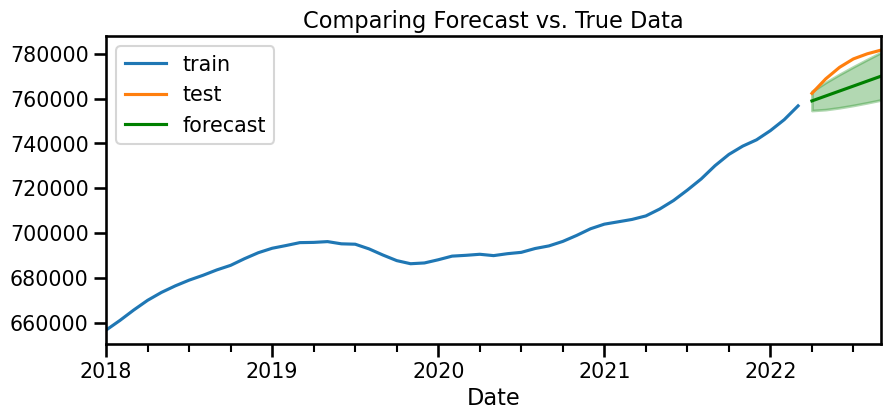

In [58]:
# Obtain summary of forecast as dataframe
forecast_df = auto_sarima.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df["mean"])

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-ycr8{background-color:#ffffff;text-align:left;vertical-align:top}
.tg .tg-iqvr{background-color:#FFF;border-color:inherit;color:rgba(0, 0, 0, 0.87);text-align:right;vertical-align:middle}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
.tg .tg-c6of{background-color:#ffffff;border-color:inherit;text-align:left;vertical-align:top}
.tg .tg-6z5m{background-color:#FFF;border-color:inherit;color:rgba(0, 0, 0, 0.87);font-weight:bold;text-align:right;
  vertical-align:middle}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-0pky"></th>
    <th class="tg-0pky" colspan="4">OG Model</th>
    <th class="tg-c6of"></th>
    <th class="tg-0pky" colspan="4">SARIMA with Gridsearch</th>
    <th class="tg-ycr8"></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0pky"></td>
    <td class="tg-0pky">-</td>
    <td class="tg-0pky">MAE</td>
    <td class="tg-0pky">=</td>
    <td class="tg-0pky">4,301.086</td>
    <td class="tg-c6of">x</td>
    <td class="tg-0pky">-</td>
    <td class="tg-0pky">MAE</td>
    <td class="tg-0pky">=</td>
    <td class="tg-0pky">9,586.366</td>
    <td class="tg-ycr8"></td>
  </tr>
  <tr>
    <td class="tg-0pky"></td>
    <td class="tg-0pky">-</td>
    <td class="tg-0pky">MSE</td>
    <td class="tg-0pky">=</td>
    <td class="tg-0pky">37,429,951.445</td>
    <td class="tg-c6of">x</td>
    <td class="tg-0pky">-</td>
    <td class="tg-0pky">MSE</td>
    <td class="tg-0pky">=</td>
    <td class="tg-0pky">101,997,632.835</td>
    <td class="tg-ycr8"></td>
  </tr>
  <tr>
    <td class="tg-0pky"></td>
    <td class="tg-0pky">-</td>
    <td class="tg-0pky">RMSE</td>
    <td class="tg-0pky">=</td>
    <td class="tg-0pky">6,118.002</td>
    <td class="tg-c6of">x</td>
    <td class="tg-0pky">-</td>
    <td class="tg-0pky">RMSE</td>
    <td class="tg-0pky">=</td>
    <td class="tg-0pky">10,099.388</td>
    <td class="tg-ycr8"></td>
  </tr>
  <tr>
    <td class="tg-0pky"></td>
    <td class="tg-0pky">-</td>
    <td class="tg-0pky">R^2</td>
    <td class="tg-0pky">=</td>
    <td class="tg-0pky">0.170</td>
    <td class="tg-c6of">x</td>
    <td class="tg-0pky">-</td>
    <td class="tg-0pky">R^2</td>
    <td class="tg-0pky">=</td>
    <td class="tg-0pky">-1.261</td>
    <td class="tg-ycr8"></td>
  </tr>
  <tr>
    <td class="tg-0pky"></td>
    <td class="tg-0pky">-</td>
    <td class="tg-0pky">MAPE</td>
    <td class="tg-0pky">=</td>
    <td class="tg-0pky">0.55%</td>
    <td class="tg-c6of">x</td>
    <td class="tg-0pky">-</td>
    <td class="tg-0pky">MAPE</td>
    <td class="tg-0pky">=</td>
    <td class="tg-0pky">1.24%</td>
    <td class="tg-ycr8"></td>
  </tr>
  <tr>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-6z5m"><span style="font-weight:bold">AIC</span></td>
    <td class="tg-iqvr">821.706</td>
    <td class="tg-0pky"></td>
    <td class="tg-c6of">x</td>
    <td class="tg-0pky"></td>
    <td class="tg-6z5m"><span style="font-weight:bold">AIC</span></td>
    <td class="tg-iqvr">912.728</td>
    <td class="tg-0pky"></td>
    <td class="tg-ycr8"></td>
  </tr>
  <tr>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-6z5m"><span style="font-weight:bold">BIC</span></td>
    <td class="tg-iqvr">838.732</td>
    <td class="tg-0pky"></td>
    <td class="tg-c6of">x</td>
    <td class="tg-0pky"></td>
    <td class="tg-6z5m"><span style="font-weight:bold">BIC</span></td>
    <td class="tg-iqvr">918.464</td>
    <td class="tg-0pky"></td>
    <td class="tg-ycr8"></td>
  </tr>
  <tr>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-c6of"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-ycr8"></td>
  </tr>
  <tr>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-c6of"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0lax"></td>
  </tr>
</tbody>
</table>

*  The original model appeared to perform better in all metrics than the gridsearch optimized model.

### Forcast

In [66]:
forecast_dfog.index[0],forecast_dfog.index[-1]


(Timestamp('2022-04-01 00:00:00', freq='MS'),
 Timestamp('2022-09-01 00:00:00', freq='MS'))

In [67]:
starting_value = forecast_dfog['mean'].iloc[0]
starting_value

762895.2507752032

In [68]:
final_value = forecast_dfog['mean'].iloc[-1]
final_value

793845.7088381893

In [69]:
change = final_value - starting_value
change

30950.45806298603

In [70]:
perc_change = (change / starting_value) * 100
perc_change

4.056973487714891

### Answer the Following Questions

* What is the predicted home value in New York City 6 months into the future (beyond the dataset)?

$793,845.71

What is the percent change in home values in New York City by the end of the 6-month forecast (beyond the dataset)?

4.06%